In [61]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os
import numpy as np
import re
import random
import nltk
from scipy import sparse
from scipy.sparse import csr_matrix, vstack
from textblob import TextBlob
from langdetect import detect_langs
import pickle
from datetime import datetime

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [62]:
if os.path.exists("data"): 
    rootPath = "data" + os.sep
elif os.path.exists("dataset"):
    rootPath = "dataset" + os.sep
else:
    rootPath = input("Relative Folder: ").replace("\"", "").replace("\'", "").replace(os.sep, "") + os.sep

if not rootPath.endswith(os.sep) and not rootPath.endswith("/"):
    rootPath += os.sep


classes = []
data = []
for directory in os.listdir(rootPath):
    if os.path.isdir(rootPath + directory):
        classes.append(directory)
        currentWork = os.path.join(rootPath + directory)
        for file in os.listdir(currentWork):
            song = str(file).replace(".txt", "")
            currentFile = os.path.join(currentWork, file)
            '''
            with open(currentFile, 'r', encoding='UTF-8') as f:
                lines = f.readlines()
            with open(currentFile, 'w', encoding='UTF-8') as f:
                f.writelines(lines[1:])
            '''
            with open(currentFile, 'r', encoding='UTF-8') as f:
                lyric = f.read()
                size = os.path.getsize(currentFile)
                if size != 0:
                    data.append((directory, song, lyric))
    	            #print(currentFile)
                # lyric = "".join(ch for ch in lyric if unicodedata.category(ch)[0] != 'C')
                #if lyric!='' or lyric.isspace()==False:
                    #data.append((directory, song, lyric))

song_df = pd.DataFrame(data, columns=['artist','song', 'text'])
song_df

,artist,song,text
0,Adele,All I Ask - Adele,[00:14.230]I will leave my heart at the door\n...
1,Adele,All Night Parking (with Erroll Garner) Interlu...,[00:10.722]\n[00:29.181] I know you've got thi...
2,Adele,Best For Last - Adele,"[00:12.599]Wait, do you see my heart on my sle..."
3,Adele,Can I Get It - Adele,[00:04.566]\n[00:04.866] Pave me a path to fol...
4,Adele,Chasing Pavements - Adele,"[00:06.316]I've made up my mind,\n[00:08.777]\..."
...,...,...,...
3564,ZAYN,Vibez - ZAYN,[00:18.811]Don't keep me waiting\n[00:21.892]I...
3565,ZAYN,When Love's Around - ZAYN,"[00:21.724]Mm, never been in love\n[00:25.257]..."
3566,ZAYN,Windowsill - ZAYN,"[00:11.816]F!ckin' on the countertop, window t..."
3567,ZAYN,wRoNg - ZAYN,[00:00.00]wRoNg (Explicit) - ZAYN/Kehlani\n[00...


In [63]:
print(song_df['text'].iloc[300])

[00:05.55]Lil Mama and Avril Lavinge REMIX
[00:07.97]
[00:08.49]Lil Mama and Avril Lavinge REMIX
[00:11.48]Lil Mama and Avril Lavinge
[00:12.87]
[00:13.70]Hey hey you you I don't like your girlfriend
[00:16.58]No way no way I think you need a new one
[00:19.79]Hey hey you you I could be your girlfriend
[00:22.70]I could be your girl Lil Mama be your girlfriend
[00:25.43]Hey hey you you I know that you like me
[00:28.44]No way no way you know it's no a secret
[00:31.24]Hey hey you you I want to be your girlfriend
[00:34.50]I could be your girl Lil Mama be your girlfriend
[00:36.59]
[00:37.53]Don't get it twisted Lil Mama got my paper on
[00:40.46]That means im a paper chaser I chase my paper on
[00:43.34]And I know we chasin paper that you be chasin on
[00:45.99]I just deliver the lyrics that people focus on
[00:48.99]Hands and a boob and a chopped up song
[00:50.47]Put it in a store and they go cops on
[00:52.18]Everybody know that its no combo
[00:53.40]Ya Betta lay low like popo
[00:

Brackets

In [64]:
text_in_round_brackets = sum(list(song_df['text'].map(lambda s: re.findall(r'\((.*?)\)',s))), [])
print('Number of round brackets: {}'.format(len(text_in_round_brackets)))

Number of round brackets: 8328


In [65]:
random.seed(0)
random.choices(text_in_round_brackets, k=20)

['loving me',
 'Oh, yeah-yeah-yeah-yeah',
 'ooh, yeah',
 'I\xa0wanna\xa0go',
 '*****, pick up your phone',
 'I might just',
 'Why you so mad?',
 'Alright',
 'All we got are',
 'And I like you',
 'Hudson Valley, NY',
 'understanding',
 'Glow',
 'Oh-oh',
 'Gimme your love, gimme your love',
 'and i',
 'Hope it never ends',
 'Mark',
 'no sleep',
 'No one has to know']

In [66]:
text_in_square_brackets = sum(list(song_df['text'].map(lambda s: re.findall(r'\[(.*?)\]',s))), [])
# text_in_square_brackets = sum(list(song_df['text'].map(lambda s: re.findall(r'\[.*?\] ', s))), [])
print('Number of square brackets: {}'.format(len(text_in_square_brackets)))

Number of square brackets: 185120


In [67]:
random.seed(0)
random.choices(text_in_square_brackets, k=20)
text_in_square_brackets[0]

'00:14.230'

In [68]:
text_in_curly_brackets = sum(list(song_df['text'].map(lambda s: re.findall(r'\{(.*)\}',s))), [])
print('Number of square brackets: {}'.format(len(text_in_curly_brackets)))

Number of square brackets: 3


In [69]:
# remove round brackets but not text within
song_df['text'] = song_df['text'].map(lambda s: re.sub(r'\(|\)', '', s))

# remove square brackest and text within
song_df['text'] = song_df['text'].map(lambda s: re.sub(r'\[(.*?)\]', '', s))
song_df['text'] = song_df['text'].map(lambda s: re.sub(r'\{(.*?)\}', '', s))

remove lines

In [70]:
# count number of lines
song_df['lines'] = song_df['text'].map(lambda t: len(re.findall(r'\n', t)))
# remove line breaks
song_df['text'] = song_df['text'].map(lambda s: re.sub(r' \n|\n', ' ', s))

abbreviation

In [71]:
replacement_pattern = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'I\'m', 'I am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would')
]

In [72]:
class RegexpReplacer(object):
    def __init__(self, patterns = replacement_pattern):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    def replace(self, text):
        s = text
        for (patterns, repl) in self.patterns:
            (s, count) = re.subn(patterns, repl, s)
        return s 

In [73]:
replacer = RegexpReplacer()
song_df['text'] = song_df['text'].map(replacer.replace)
print(song_df['text'].iloc[0])

I will leave my heart at the door I will not say a word They have all been said before you know So why do not we just play pretend Like we are not scared of what is coming next Or scared of having nothing left look do not get me wrong I know there is no tomorrow All I ask  Is if this is my last night with you Hold me like I am more than just a friend Give me a memory I can use Take me by the hand while we do what lovers do It matters how this ends Cause what if I never love again  I do not need your honesty It is already in your eyes and I am sure my eyes they speak for me No one knows me like you do And since you are the only one that mattered, tell me who do I run to  Look do not get me wrong I know there is no tomorrow All I ask  Is if this is my last night with you Hold me like I am more than just a friend Give me a memory I can use Take me by the hand while we do what lovers do It matters how this ends Cause what if I never love again  Let this be our lesson in love Let this be th

In [74]:
df = song_df[['text', 'artist']]
df

,text,artist
0,I will leave my heart at the door I will not s...,Adele
1,I know you have got things to do I do too I...,Adele
2,"Wait, do you see my heart on my sleeve? It is ...",Adele
3,Pave me a path to follow And I will tread a...,Adele
4,"I have made up my mind, Do not need to think ...",Adele
...,...,...
3564,Do not keep me waiting I have been waiting all...,ZAYN
3565,"Mm, never been in love Never really loved some...",ZAYN
3566,"F!ckin' on the countertop, window to the floor...",ZAYN
3567,wRoNg Explicit - ZAYN/Kehlani Oh when I in th...,ZAYN


In [75]:
df.to_csv('./lyric.csv', header=True, index=False)

In [76]:


import re


import pandas as pd
from numpy.random import RandomState

import torchtext
from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.vocab import GloVe
from torchtext.data import Iterator, BucketIterator
import torchtext.datasets
from torchtext.datasets import IMDB, SST

import spacy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt




In [77]:
#%% Split whole dataset into train and valid set
df = pd.read_csv('./lyric.csv')
rng = RandomState()

tr = df.sample(frac=0.8, random_state=rng)
tst = df.loc[~df.index.isin(tr.index)]
tr.to_csv('train.csv', index=False)
tst.to_csv('valid.csv', index=False)


In [78]:
from spacy.lang.en import English
#%% Prepare the dataset via torchtext
# spacy_en = spacy.load('en', disable=['tagger', 'parser', 'ner', 'textcat'
#                                      'entity_ruler', 'sentencizer', 
#                                      'merge_noun_chunks', 'merge_entities',
#                                      'merge_subtokens'])

spacy_en = English(disable=['tagger', 'parser', 'ner', 'textcat'
                                     'entity_ruler', 'sentencizer', 
                                     'merge_noun_chunks', 'merge_entities',
                                     'merge_subtokens'])

def tokenizer(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
  
# set up fields
def clean_str(string):
    
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()
  
  


#Creating field for text and label
TEXT = Field(sequential=True, tokenize=tokenizer, lower=True)
LABEL = Field(sequential=False)

#clean the text
TEXT.preprocessing = torchtext.data.Pipeline(clean_str)

In [79]:

train_datafield = [('text', TEXT),  ('label', LABEL)]
train = TabularDataset(path ='./train.csv',  
                             format='csv',
                             skip_header=True,
                             fields=train_datafield)


test_datafield = [('text', TEXT),  ('label',LABEL)]

test = TabularDataset(path ='./valid.csv', 
                       format='csv',
                       skip_header=True,
                       fields=test_datafield)

In [80]:
#%%Show some example to show the dataset
print(train[0].text,  train[0].label)
print(test[0].text,  test[0].label)

['trembling', 'starry', 'eyed', 'as', 'you', 'put', 'your', 'hand', 'in', 'mine', 'it', 'was', 'twilight', 'on', 'the', 'fourth', 'of', 'july', 'sparkling', 'colors', 'were', 'strewn', 'across', 'the', 'sky', 'and', 'we', 'sat', 'close', 'enough', 'that', 'we', 'just', 'barely', 'touched', 'while', 'roman', 'candles', 'went', 'soaring', 'above', 'us', 'and', 'baby', 'then', 'you', 'put', 'your', 'hand', 'in', 'mine', 'and', 'we', 'wandered', 'away', 'i', 'was', 'trembling', 'inside', 'but', 'i', 'wanted', 'to', 'stay', 'pressed', 'against', 'you', 'there', 'and', 'leave', 'the', 'world', 'behind', 'on', 'that', 'fourth', 'of', 'july', 'so', 'starry', 'eyed', 'on', 'the', 'flowery', 'hillside', 'breathless', 'and', 'fervid', 'amid', 'the', 'dandelions', 'as', 'it', 'swept', 'over', 'me', 'like', 'the', 'wind', 'through', 'the', 'trees', 'i', 'felt', 'you', 'sigh', 'with', 'a', 'sweet', 'intensity', 'and', 'baby', 'then', 'you', 'put', 'your', 'hand', 'in', 'mine', 'and', 'we', 'floated'

In [81]:
#%% Check the dataset
TEXT.build_vocab(train, vectors= 'glove.6B.300d')
LABEL.build_vocab(train)
#%% load the pretrained embedding
vocab = TEXT.vocab

#%% Create the Iterator for datasets (Iterator works like dataloader)

train_iter = Iterator(
        train, 
        batch_size=64,
        device=torch.device('cuda'), 
        sort_within_batch=False,
        repeat=False)

test_iter = Iterator(test, batch_size=16, device=torch.device('cuda'), 
                     sort_within_batch=False, repeat=False)

In [82]:
#%% Text CNN model
class textCNN(nn.Module):
    
    def __init__(self, vocab_built, emb_dim, dim_channel, kernel_wins, num_class):
        super(textCNN, self).__init__()
        #load pretrained embedding in embedding layer.
        self.embed = nn.Embedding(len(vocab_built), emb_dim)
        self.embed.weight.data.copy_(vocab_built.vectors)
    
        #Convolutional Layers with different window size kernels
        self.convs = nn.ModuleList([nn.Conv2d(1, dim_channel, (w, emb_dim)) for w in kernel_wins])
        #Dropout layer
        self.dropout = nn.Dropout(0.2)
        
        #FC layer
        self.fc = nn.Linear(len(kernel_wins)*dim_channel, num_class)
        
    def forward(self, x):
        emb_x = self.embed(x)
        emb_x = emb_x.unsqueeze(1)

        con_x = [conv(emb_x) for conv in self.convs]

        pool_x = [F.max_pool1d(x.squeeze(-1), x.size()[2]) for x in con_x]
        
        fc_x = torch.cat(pool_x, dim=1)
        
        fc_x = fc_x.squeeze(-1)

        fc_x = self.dropout(fc_x)
        logit = self.fc(fc_x)
        return logit
        

#%% Training the Model
def train(model, device, train_itr, optimizer, epoch, max_epoch):
    model.train()
    corrects, train_loss = 0.0,0
    for batch in train_itr:
        text, target = batch.text, batch.label
        text = torch.transpose(text,0, 1)
        target.data.sub_(1)
        text, target = text.to(device), target.to(device)
        optimizer.zero_grad()
        logit = model(text)
        
        loss = F.cross_entropy(logit, target)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.item()
        result = torch.max(logit,1)[1]
        corrects += (result.view(target.size()).data == target.data).sum()
    
    size = len(train_itr.dataset)
    train_loss /= size 
    accuracy = 100.0 * corrects/size
  
    return train_loss, accuracy
    
def valid(model, device, test_itr):
    model.eval()
    corrects, test_loss = 0.0,0
    for batch in test_itr:
        text, target = batch.text, batch.label
        text = torch.transpose(text,0, 1)
        target.data.sub_(1)
        text, target = text.to(device), target.to(device)
        
        logit = model(text)
        loss = F.cross_entropy(logit, target)

        
        test_loss += loss.item()
        result = torch.max(logit,1)[1]
        corrects += (result.view(target.size()).data == target.data).sum()
    
    size = len(test_itr.dataset)
    test_loss /= size 
    accuracy = 100.0 * corrects/size
    
    return test_loss, accuracy

In [83]:
#%%
model = textCNN(vocab, 300, 100, [3, 4 , 5] , 41).to('cuda')
# print the model summery
print(model)    
    
train_loss = []
train_acc = []
test_loss = []
test_acc = []
best_test_acc = -1

# Use GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 20+1):
    #train loss
    tr_loss, tr_acc = train(model, device, train_iter, optimizer, epoch, 100)
    print('Train Epoch: {} \t Loss: {} \t Accuracy: {}%'.format(epoch, tr_loss, tr_acc))
    
    ts_loss, ts_acc = valid(model, device, test_iter)
    print('Valid Epoch: {} \t Loss: {} \t Accuracy: {}%'.format(epoch, ts_loss, ts_acc))
    
    if ts_acc > best_test_acc:
        best_test_acc = ts_acc
        #save paras(snapshot)
        print("model saves at {} accuracy".format(best_test_acc))
        torch.save(model.state_dict(), "textCNN_IMDB_best_valid")
        
    train_loss.append(tr_loss)
    train_acc.append(tr_acc.cuda().data.cpu())
    test_loss.append(ts_loss)
    test_acc.append(ts_acc.cuda().data.cpu())

textCNN(
  (embed): Embedding(15780, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=300, out_features=41, bias=True)
)
Train Epoch: 1 	 Loss: 0.05651872011909552 	 Accuracy: 5.21891450881958%
Valid Epoch: 1 	 Loss: 0.21840273599330784 	 Accuracy: 7.002801418304443%
model saves at 7.002801418304443 accuracy
Train Epoch: 2 	 Loss: 0.05121016727855034 	 Accuracy: 17.162872314453125%
Valid Epoch: 2 	 Loss: 0.2098826877877158 	 Accuracy: 10.224089622497559%
model saves at 10.224089622497559 accuracy
Train Epoch: 3 	 Loss: 0.04499299329968134 	 Accuracy: 30.75306510925293%
Valid Epoch: 3 	 Loss: 0.19681696063664114 	 Accuracy: 18.347339630126953%
model saves at 18.347339630126953 accuracy
Train Epoch: 4 	 Loss: 0.03752808913249268 	 Accuracy: 42.451839447021

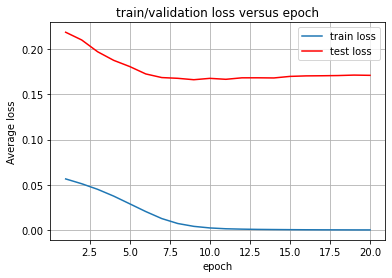

[0.05651872011909552, 0.05121016727855034, 0.04499299329968134, 0.03752808913249268, 0.02903643481159377, 0.020494659560783106, 0.012744566020531329, 0.007297151049047761, 0.004153741434242596, 0.002413542096335082, 0.0014975842786545093, 0.0010822182609300061, 0.0008031944312063908, 0.0006367144737581865, 0.0005128818993079892, 0.0003993336091734691, 0.00033857021774385523, 0.00029667810734276595, 0.00025195587074119865, 0.00023072653347316432]


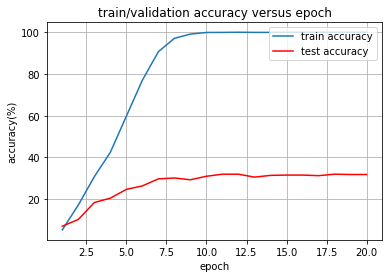

In [84]:
    import matplotlib.pyplot as plt
    #plot train/validation loss versus epoch
    x = list(range(1, 20+1))
    plt.figure()
    plt.title("train/validation loss versus epoch")
    plt.xlabel("epoch")
    plt.ylabel("Average loss")
    plt.plot(x, train_loss,label="train loss")
    plt.plot(x, test_loss, color='red', label="test loss")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


    print(train_loss)
    test_acc
    #plot train/validation accuracy versus epoch
    x = list(range(1, 20+1))
    plt.figure()
    plt.title("train/validation accuracy versus epoch")
    plt.xlabel("epoch")
    plt.ylabel("accuracy(%)")

    plt.plot(x, train_acc,label="train accuracy")
    plt.plot(x, test_acc, color='red', label="test accuracy")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()